# House Prices: Advanced Regression Techniques

## Линейные модели

Необходимо предсказать цену недвижимости по имеющимся описаниям домов. Это задача из конкурса Kaggle, с условиями и описанием признаков можно ознакомиться здесь:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Во второй части решения будут использоваться линейные модели.

* Подбор параметров будем осуществлять на кросс-валидации по 3-м блокам и с помощью контроля над переобучением по отложенной выборке.
* Выбор лучшей модели - по отложенной выборке.
* Метрика качества - RMSE над логарифмом целевой переменной.
* В качестве кодирования категориальных признаков будем использовать one-hot encoding (замену на бинарные признаки).
* Числовые признаки будем масштабировать, т.к. будем использовать L1 и L2 регуляризацию.
* Обработка пропущенных значений: 0 для числовых признаков, новое значение - для категориальных.

In [32]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from matplotlib import pylab as plt
%matplotlib inline

## Загрузка данных

In [2]:
data_train = pd.read_csv('train.csv', index_col = 'Id')
data_train[:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


## Предобработка данных

#### Целевая переменная

Рассмотрим целевую переменную. В качестве метрики для оценки качества алгоритмов в конкурсе используется RMSE над логарифмами цен. Это делается для того, чтобы ошибки при определении цены дорогой и дешевой недвижимости имели одинаковый вес. Поэтому мы также будем обучать модели на логарифме от исходной целевой переменной.

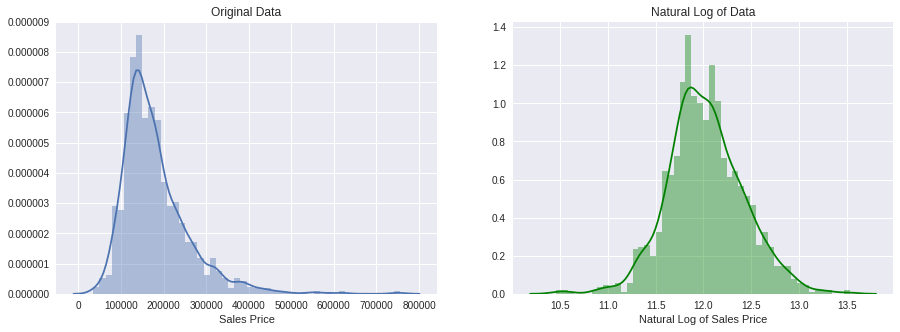

In [3]:
y = np.log(data_train['SalePrice'])

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.distplot(data_train['SalePrice'], bins = 50)
plt.title('Original Data')
plt.xlabel('Sales Price')

plt.subplot(1, 2, 2)
sns.distplot(y, bins = 50, color = 'g')
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sales Price')

#### Корреляция между признаками и целевой переменной

Рассмотрим теперь матрицу объекты - признаки. Для начала разделим все признаки на два типа: числовые и категориальные, поскольку мы будем обрабатывать их по-разному.

In [4]:
numeric_cols = []
categorical_cols = []
for column in data_train.drop('SalePrice', axis = 1, inplace = False).columns.values:
    if data_train[column].dtype == 'object':
        categorical_cols.append(column)
    else:
        numeric_cols.append(column)

# Некоторые признаки, имеющие в качестве значений числа, тем не менее являются
# категориальными. Использование их как числовых ведет к ухудшению результата
for feature in ['MSSubClass', 'MoSold']:
    numeric_cols.remove(feature)
    categorical_cols.append(feature)

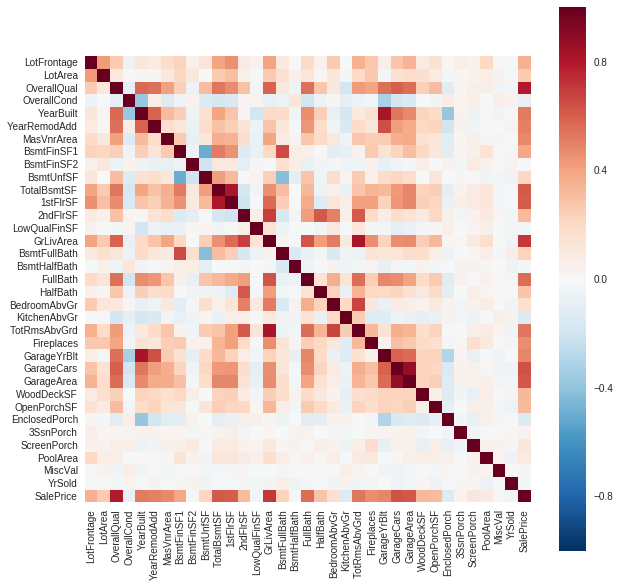

In [5]:
plt.figure(figsize = (10,10))
sns.heatmap(data_train[numeric_cols + ['SalePrice']].corr(), square=True)

Видно, что некоторые признаки линейно зависимы. Наиболее сильная зависимость наблюдается для:
* 1stFlrSF и TotalBsmtSF - площадь подвала и первого этажа коррелируют, это вполне логично;
* GarageArea и GarageCars - чем больше машиномест в гараже, тем больше должна быть его площадь;
* GarageYrBlt и YearBuilt - гараж обычно строился одновременно с домом.

Также есть некоторые признаки, которые заметно коррелируют с целевой переменной. Это:
* OverallQual - чем больше общая оценка качества материалов и готовности дома, тем выше цена;
* GrLivArea - цену часто даже указывают на единицу площади, так что чем больше жилая площадь, тем больше цена;
* TotalBsmtSF, 1stFlrSF, GarageCars, GarageArea - эти признаки также характеризуют площадь, в том числе нежилую, поэтому тоже коррелируют с ценой.

Таким образом, здесь, скорее всего, будут хорошо работать линейные модели. Также стоит попробовать использовать L1 - регуляризацию.

#### Заполнение пропусков

Посмотрим, сколько и в каких колонках есть пропуски:

In [6]:
print('Number of missing values in columns:')
for i in range(0, len(data_train.columns)):
    if data_train.ix[:, i].isnull().sum() != 0:
        print (data_train.columns[i], ': ', data_train.ix[:, i].isnull().sum())

Number of missing values in columns:
LotFrontage :  259
Alley :  1369
MasVnrType :  8
MasVnrArea :  8
BsmtQual :  37
BsmtCond :  37
BsmtExposure :  38
BsmtFinType1 :  37
BsmtFinType2 :  38
Electrical :  1
FireplaceQu :  690
GarageType :  81
GarageYrBlt :  81
GarageFinish :  81
GarageQual :  81
GarageCond :  81
PoolQC :  1453
Fence :  1179
MiscFeature :  1406


Необходимо отметить, что для многих признаков nan - это отдельное значение. Например, nan в GarageType и других признаках, описывающих состояние гаража, означает, что гаража вообще нет. В основном такое правило соблюдается для категориальных и порядковых признаков. Поэтому мы будем заменять пропуски новой категорией nan.

In [7]:
data_train[categorical_cols].fillna('nan')
X_cat = pd.DataFrame(data_train[categorical_cols].applymap(str))
X_cat.isnull().values.any()

False

Для числовых признаков лучше заменить пропуски на 0, т.к. в линейных моделях они не будут влиять на результат.

In [8]:
X_num = pd.DataFrame(columns = numeric_cols)
for i in range(0, len(data_train[numeric_cols].columns)):
    X_num.ix[:, i] = data_train[numeric_cols].ix[:, i].fillna(0)
X_num.isnull().values.any()

False

#### Кодирование категориальных признаков

Мы будем использовать one-hot encoding.

In [9]:
encoder = DV(sparse = False)
X_cat_encoded = encoder.fit_transform(X_cat.T.to_dict().values())

#### Формирование отложенной выборки

In [10]:
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size = 0.3, random_state = 0)
X_cat_train, X_cat_test = train_test_split(X_cat_encoded, test_size = 0.3, random_state = 0)

#### Масштабирование числовых признаков

Поскольку мы будем использовать регуляризацию, полезно отмасштабировать признаки, несмотря на то, что это - задача регрессии.

In [11]:
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train, y_train)
X_num_test_scaled = scaler.transform(X_num_test)

#### Формирование итоговых обучающей и тестовой выборки

In [12]:
X_train = np.hstack([X_num_train_scaled, X_cat_train])
X_test = np.hstack([X_num_test_scaled, X_cat_test])

## Обучение моделей

#### Метрика

In [13]:
# Scorer будет использоваться для оценки качества на кросс-валидации
def score_func(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

scorer = make_scorer(score_func, greater_is_better = False)

### Ridge

Будем подбирать коэффициент для L2 регуляризатора, оценивая качество на обучающей выборке по кросс-валидации и контролируя переобучение с помощью отложенной выборки. Результаты после нескольких экспериментов:

CPU times: user 43.6 s, sys: 15.1 s, total: 58.7 s
Wall time: 44.9 s


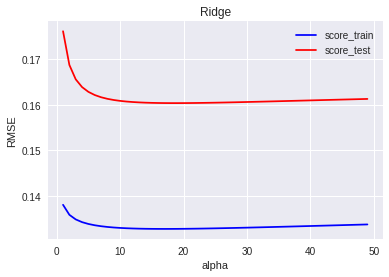

In [14]:
%%time
alphas = np.arange(1, 50, 1)
scores_train = []
scores_test = []
    
for alpha in alphas:
    model = Ridge(alpha = alpha, random_state = 0)
    scores_train.append(-cross_val_score(model, X_train, y_train, cv = 3, scoring = scorer).mean())
    
    model.fit(X_train, y_train)
    scores_test.append(score_func(y_test, model.predict(X_test)))
    
plt.plot(alphas, scores_train, color = 'b', label = 'score_train')
plt.plot(alphas, scores_test, color = 'r', label = 'score_test')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Ridge')
plt.legend(loc = 'best')

In [15]:
print ('The best alpha for train sample: ', scores_train.index(min(scores_train)) + 1)
print ('The best alpha for test sample: ', scores_test.index(min(scores_test)) + 1)

The best alpha for train sample:  17
The best alpha for test sample:  19


Выберем alpha = 18 для Ridge. Это дает следующие оценки на обучающей и тестовой выборке:

In [16]:
alpha_Ridge = 18
print('Final score for Ridge on train sample: ', scores_train[alpha_Ridge - 1])
print('Final score for Ridge on test sample: ', scores_test[alpha_Ridge - 1])

Final score for Ridge on train sample:  0.132753336258
Final score for Ridge on test sample:  0.160351790872


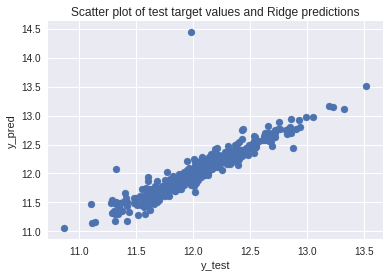

In [17]:
Ridge_best = Ridge(alpha = alpha_Ridge, random_state = 0)
Ridge_best.fit(X_train, y_train)

plt.scatter(y_test, Ridge_best.predict(X_test))
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Scatter plot of test target values and Ridge predictions')

### Lasso

Теперь попробуем L1 - регуляризацию. Подберем коэффициент для alpha аналогичным образом:

CPU times: user 10.7 s, sys: 13.7 s, total: 24.4 s
Wall time: 18.9 s


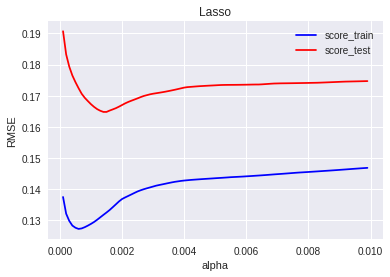

In [18]:
%%time
alphas = np.arange(0.0001, 0.01, 0.0001)
scores_train = []
scores_test = []
    
for alpha in alphas:
    model = Lasso(alpha = alpha, random_state = 0, max_iter = 100000)
    scores_train.append(-cross_val_score(model, X_train, y_train, cv = 3, scoring = scorer).mean())
    
    model.fit(X_train, y_train)
    scores_test.append(score_func(y_test, model.predict(X_test)))
    
plt.plot(alphas, scores_train, color = 'b', label = 'score_train')
plt.plot(alphas, scores_test, color = 'r', label = 'score_test')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Lasso')
plt.legend(loc = 'best')

In [19]:
print ('The best alpha for train sample: ', alphas[scores_train.index(min(scores_train))])
print ('The best alpha for test sample: ', alphas[scores_test.index(min(scores_test))])

The best alpha for train sample:  0.0006
The best alpha for test sample:  0.0014


Выберем alpha = 0.001.

In [20]:
alpha_Lasso = 0.001
print('Final score for Lasso on train sample: ', scores_train[9])
print('Final score for Lasso on test sample: ', scores_test[9])

Final score for Lasso on train sample:  0.128909249738
Final score for Lasso on test sample:  0.167284614293


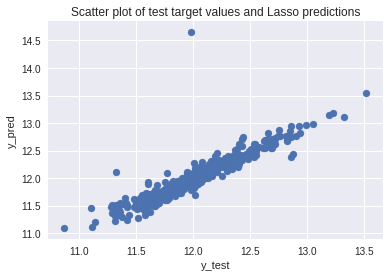

In [21]:
Lasso_best = Lasso(alpha = alpha_Lasso, random_state = 0)
Lasso_best.fit(X_train, y_train)

plt.scatter(y_test, Lasso_best.predict(X_test))
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Scatter plot of test target values and Lasso predictions')

In [22]:
coef = pd.Series(Lasso_best.coef_)
print('The number of the least significant coefficients: ', len(coef) - len(coef.unique()) - 1)

The number of the least significant coefficients:  227


## Предсказание результатов на тестовой выборке

Поскольку лучший результат на отложенной выборке показал алгоритм Ridge, мы будем использовать его. Более того, возможно, что Lasso больше подвержен переобучению, т.к. он обнуляет довольно много весов, которые могут быть, например, отсутствующими в обучающей выборке значениями категориальных признаков.

### Загрузка данных

In [23]:
data_test = pd.read_csv('test.csv', index_col = 'Id')
data_test[:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


### Предобработка данных

#### Заполнение пропусков

In [24]:
print('Number of missing values in columns:')
for i in range(0, len(data_test.columns)):
    if data_test.ix[:, i].isnull().sum() != 0:
        print (data_test.columns[i], ': ', data_test.ix[:, i].isnull().sum())

Number of missing values in columns:
MSZoning :  4
LotFrontage :  227
Alley :  1352
Utilities :  2
Exterior1st :  1
Exterior2nd :  1
MasVnrType :  16
MasVnrArea :  15
BsmtQual :  44
BsmtCond :  45
BsmtExposure :  44
BsmtFinType1 :  42
BsmtFinSF1 :  1
BsmtFinType2 :  42
BsmtFinSF2 :  1
BsmtUnfSF :  1
TotalBsmtSF :  1
BsmtFullBath :  2
BsmtHalfBath :  2
KitchenQual :  1
Functional :  2
FireplaceQu :  730
GarageType :  76
GarageYrBlt :  78
GarageFinish :  78
GarageCars :  1
GarageArea :  1
GarageQual :  78
GarageCond :  78
PoolQC :  1456
Fence :  1169
MiscFeature :  1408
SaleType :  1


In [25]:
data_test[categorical_cols].fillna('Null')
X_cat_test_sample = pd.DataFrame(data_test[categorical_cols].applymap(str))
X_cat_test_sample.isnull().values.any()

False

In [26]:
X_num_test_sample = pd.DataFrame(columns = numeric_cols)
for i in range(0, len(data_test[numeric_cols].columns)):
    X_num_test_sample.ix[:, i] = data_test[numeric_cols].ix[:, i].fillna(0)
X_num_test_sample.isnull().values.any()

False

#### Кодирование категориальных признаков

In [27]:
# заново кодируем полную обучающую выборку для полной уверенности в оценках
encoder = DV(sparse = False)
X_cat_train_sample_encoded = encoder.fit_transform(X_cat.T.to_dict().values())
X_cat_test_sample_encoded = encoder.transform(X_cat_test_sample.T.to_dict().values())

#### Масштабирование числовых признаков

In [28]:
# обучаем scaler на полной обучающей выборке
scaler = StandardScaler()
X_num_train_sample_scaled = scaler.fit_transform(X_num, y) 
X_num_test_sample_scaled = scaler.transform(X_num_test_sample)

#### Формирование итоговых обучающей и тестовой выборок

In [29]:
X_train_sample = np.hstack([X_num_train_sample_scaled, X_cat_train_sample_encoded])
X_test_sample = np.hstack([X_num_test_sample_scaled, X_cat_test_sample_encoded])

### Обучение моделей

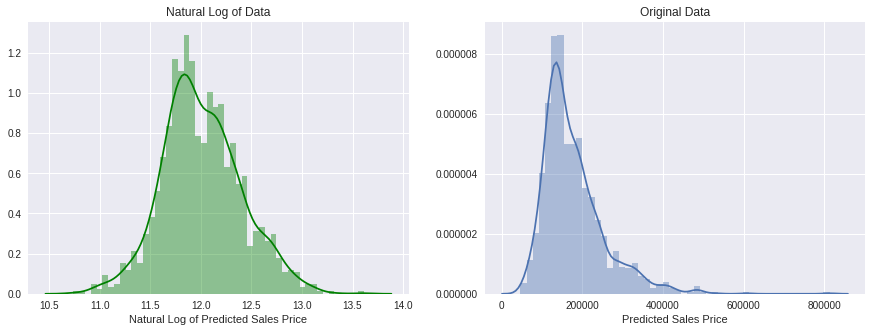

In [30]:
Ridge_regressor = Ridge(alpha = alpha_Ridge, random_state = 0)
Ridge_regressor.fit(X_train_sample, y)
predictions = Ridge_regressor.predict(X_test_sample)

answers = np.exp(predictions)
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
sns.distplot(predictions, bins = 50, color = 'g')
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Predicted Sales Price')

plt.subplot(1, 2, 2)
sns.distplot(answers, bins = 50)
plt.title('Original Data')
plt.xlabel('Predicted Sales Price')

Распределения целевой переменной и логарифма на тесте выглядят аналогично обучающей выборке. Это, конечно, не строгая оценка, но тем не менее в какой-то мере исключает грубые ошибки.

### Экспорт данных

In [31]:
pd.DataFrame(answers, index = data_test.index, columns = ['SalePrice']).to_csv('answers_Ridge')